# Image recovery

In [1]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from matplotlib import pyplot as plt
from safetensors.torch import  load_file



# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

Load both models and corrupted positions

In [2]:
archive_name = "corrupted_positions.safetensors"
loading_path = os.path.join (MODELS_DIR, archive_name)
positions = load_file(loading_path)["positions"].int().tolist()
positions = sorted(positions)

# Define the path to the saved model
archive_name = "model_pretrained_advanced_general.safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)
# Load the model state dictionary
state_dict_pretrained = load_file(loading_path)

# Define the path to the saved model
archive_name = "model_finetuned_advanced.safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)
state_dict_finetuned = load_file(loading_path)

In [3]:
gradient_weights = state_dict_pretrained['fc1.weight'][positions,:] - state_dict_finetuned['fc1.weight'][positions,:]
gradient_bias = state_dict_pretrained['fc1.bias'][positions] - state_dict_finetuned['fc1.bias'][positions]
gradient_bias_expanded = gradient_bias.unsqueeze(1)
print((gradient_weights != 0).any(dim=1).nonzero(as_tuple=True)[0])

tensor([ 0,  2,  4,  5,  7, 11, 12, 14, 15, 17, 18, 20, 21, 22, 24, 29, 30, 31,
        32, 36, 38, 39, 41, 42, 46, 48, 49, 50, 53, 56, 60, 61, 62, 63])


In [4]:
print(gradient_weights.size(), gradient_bias.size())
recovered_images = torch.div(gradient_weights, gradient_bias_expanded)
print(recovered_images)

torch.Size([64, 784]) torch.Size([64])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.5315e-01,
          7.1637e-04,  0.0000e+00],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0115e-02,
         -1.7134e-04,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.6415e-03,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.6078e-01,
         -6.9146e-06, -5.0983e-07]])


torch.Size([64, 784])
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4924e-05,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.4924e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  1.9191e-01,  4.0878e-01,  ...,  4.0863e-01,
           1.8761e-01,  0.0000e+00],
         [ 0.0000e+00,  3.4398e-01,  4.2460e-01,  ...,  4.2001e-01,
           3.0354e-01,  0.0000e+00],
         [ 0.0000e+00,  5.0692e-02,  2.2502e-01,  ...,  1.5315e-01,
           7.1637e-04,  0.0000e+00]],

        [[        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         ...,
   

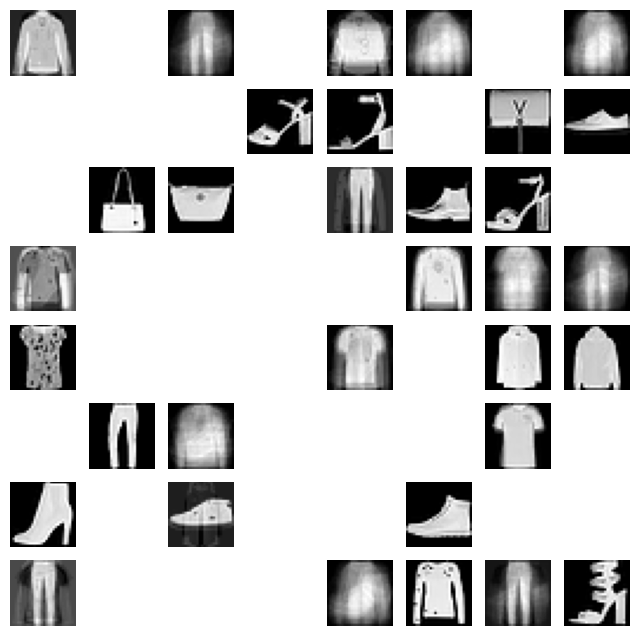

In [5]:
import math

print(recovered_images.size())
images_28x28 = recovered_images.view(-1, 28, 28)  # Ajusta el tamaño para todas las imágenes
print(images_28x28)

num_images = images_28x28.size(0)
num_cols = 8  # Número de columnas en la cuadrícula
num_rows = math.ceil(num_images / num_cols)  # Calcula el número de filas necesarias

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
axes = axes.flatten()  # Aplana la matriz de ejes para iterar fácilmente

for i in range(num_images):
    axes[i].imshow(images_28x28[i].detach().numpy(), cmap='gray')
    axes[i].axis('off')

# Oculta los ejes sobrantes si hay menos imágenes que subplots
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.show()